# Обучение нейросетей — оптимизация и регуляризация


На это семинаре будет необходимо 
1. реализовать Dropout-слой и проследить его влияние на обобщающую способность сети 
2. реализовать BatchNormalization-слой

## Dropout

Как всегда будем экспериментировать на датасете MNIST. MNIST является стандартным бенчмарк-датасетом, и его можно подгрузить средствами pytorch.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
input_size = 784
num_classes = 10
batch_size = 128

train_dataset = dsets.MNIST(root='./MNIST/', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.MNIST(root='./MNIST/', 
                                  train=False, 
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Определим ряд стандартных функций с прошлых семинаров

In [3]:
def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        data = x_batch
        target = y_batch

        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target).cpu()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log    

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):    
        data = x_batch
        target = y_batch

        output = model(data)
        loss = F.nll_loss(output, target).cpu()

        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batch_size)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
        
        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')   
        
        print("Epoch: {2}, val loss: {0}, val accuracy: {1}".format(np.mean(val_loss), np.mean(val_acc), epoch))


Создайте простейшую однослойную модель - однослойную полносвязную сеть и обучите ее с параметрами оптимизации, заданными ниже.

In [ ]:
model = nn.Sequential(
                    nn.Flatten(1),
                    nn.Linear(input_size, num_classes),
                    nn.LogSoftmax(dim=-1)
)

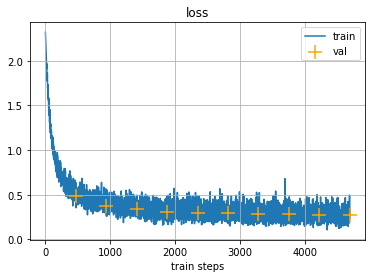

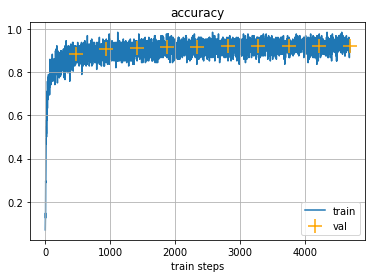

Epoch: 9, val loss: 0.2725310136764487, val accuracy: 0.923061728477478


In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(model, opt, 10)

Параметром обученной нейросети является матрица весов, в которой каждому классу соответствует один из 784-мерных столбцов. Визуализируйте обученные векторы для каждого из классов, сделав их двумерными изображениями 28-28. Для визуализации можно воспользоваться кодом для визуализации MNIST-картинок с предыдущих семинаров.

In [ ]:
model._modules['1'].weight.shape

torch.Size([10, 784])

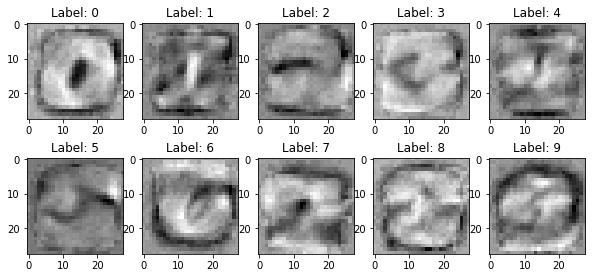

In [ ]:
weights = model._modules['1'].weight.detach().numpy()
plt.figure(figsize=[10, 12])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Реализуйте Dropout-слой для полносвязной сети. Помните, что этот слой ведет себя по-разному во время обучения и во время применения. 

In [ ]:
n, p = 1, .5  # number of trials, probability of each trial
s = np.random.binomial(n, p, 10)
s

array([0, 1, 1, 0, 0, 1, 1, 0, 1, 1])

In [ ]:
m = nn.Dropout(p=0.6)
input = torch.randn(4, 3)
print(input)
output = m(input)
output

tensor([[ 0.6827, -1.0827,  0.0901],
        [ 0.8054, -0.4594,  0.3893],
        [ 1.9973, -0.7651,  1.6682],
        [-0.4813, -0.4344,  0.9364]])


tensor([[ 1.7068, -0.0000,  0.2253],
        [ 0.0000, -1.1485,  0.9732],
        [ 4.9933, -1.9129,  0.0000],
        [-0.0000, -0.0000,  0.0000]])

In [ ]:
n, p = 1, .5  # number of trials, probability of each trial
s = np.random.binomial(n, p, input.shape)
print(s)
# output * (1 / (1 - 0.8))
input.masked_fill(torch.from_numpy(s), 0) * (1 / (1 - 0.8))

[[0 1 0]
 [1 1 0]
 [0 0 0]
 [1 1 0]]


tensor([[ 3.4135,  0.0000,  0.4505],
        [ 0.0000,  0.0000,  1.9465],
        [ 9.9865, -3.8257,  8.3411],
        [ 0.0000,  0.0000,  4.6819]])

In [ ]:
# эту ячейку в тестах я буду сохранять в отдельный файл, поэтому не нужно
# изменять имя класса, убирать импорты (добавлять, в принципе, можно)
# добавлять в ячейку какой-то посторонний код, не связанный с реализацией этого класса

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class DropoutLayer(nn.Module): # не надо переименовыввать этот класс
    """
    https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
    """
    def __init__(self, p=0.5, inplace=False):
        super().__init__()
        self.p = p
        self.inplace = inplace

    def forward(self, input):
        # todo
        # подсказка: скорее всего, вам понадобится ф-я rand_like https://pytorch.org/docs/stable/generated/torch.randn_like.html
        # и masked_fill_ https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html

        if self.training:
          s = torch.from_numpy(np.random.binomial(1, self.p, input.shape)) # n, p = 1, .5  # number of trials, probability of each trial  
          if self.inplace:            
            input.masked_fill_(s, 0)
            input *= 1 / (1 - self.p)
            return input
          else:            
            return input.masked_fill(s, 0) * (1 / (1 - self.p))

        else:
            return input


In [ ]:
from tqdm.auto import tqdm

def test_dropout_train():

    zero_proba = 0.9
    do = DropoutLayer(p=zero_proba, inplace=False)

    assert do.p == zero_proba, f"zero_proba is ok"

    do.train()

    input_tensor = torch.rand( (7, 3, 28, 28) )
    input_tensor_clone = input_tensor.clone()

    dropouted_tensor = do(input_tensor)

    assert (input_tensor_clone == input_tensor).all(), "input tensor was not changed"

    zeroed_values = (dropouted_tensor == 0).sum()
    # print("input_tensor.numel()", input_tensor.numel())
    expected_zeroed_values = input_tensor.numel() * do.p

    assert (zeroed_values - expected_zeroed_values).abs() < 200, f"zeroed_values={zeroed_values} expected_zeroed_values={expected_zeroed_values}"

    input_module = input_tensor.abs().sum()
    output_module = dropouted_tensor.abs().sum()
    module_diff = (input_module - output_module).abs()
    assert module_diff < 1000, f"input_norm {input_module}, outout_norm {output_module}, diff={module_diff}"

def test_dropout_eval():

    with torch.no_grad():

        zero_proba = 0.9
        do = DropoutLayer(p=zero_proba, inplace=False)

        assert do.p == zero_proba, f"zero_proba is ok"

        do.eval()

        input_tensor = torch.rand( (7, 3, 28, 28) )
        input_tensor_clone = input_tensor.clone()

        dropouted_tensor = do(input_tensor)

        assert (input_tensor_clone == input_tensor).all(), "input tensor was not changed"
        assert (dropouted_tensor == input_tensor_clone).all(), "output tensor equals to input"


for _ in tqdm(range(100)):
    test_dropout_train()
    test_dropout_eval()

  0%|          | 0/100 [00:00<?, ?it/s]

Добавьте Dropout-слой в архитектуру сети, проведите оптимизацию с параметрами, заданными ранее, визуализируйте обученные веса. Есть ли разница между весами обученными с Dropout и без него? Параметр Dropout возьмите равным 0.7

In [ ]:
modelDp = nn.Sequential(
                    nn.Flatten(1),
                    DropoutLayer(p=0.7),
                    nn.Linear(28 * 28, 10),
                    nn.LogSoftmax(dim=-1)
    )

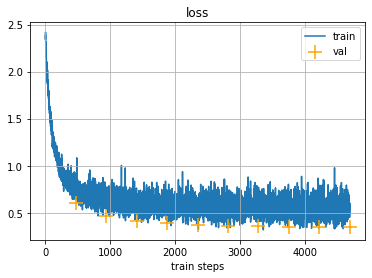

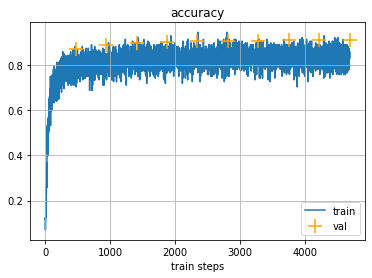

Epoch: 9, val loss: 0.34415261772803113, val accuracy: 0.910304605960846


In [ ]:
opt = torch.optim.Adam(modelDp.parameters(), lr=0.0005)
train(modelDp, opt, 10)

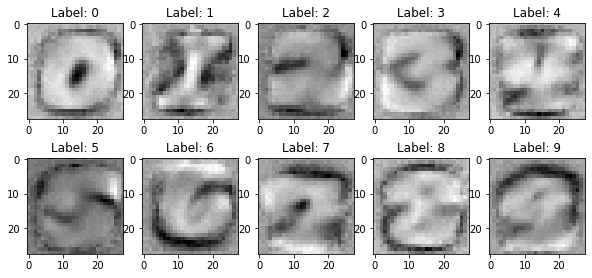

In [ ]:
weights = modelDp._modules['2'].weight.detach().numpy()
plt.figure(figsize=[10, 12])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Обучите еще одну модель, в которой вместо Dropout-регуляризации используется L2-регуляризация с коэффициентом 0.05. (Параметр weight_decay в оптимизаторе). Визуализируйте веса и сравните с двумя предыдущими подходами.

In [ ]:
model = nn.Sequential(
    nn.Flatten(1),
    nn.Linear(input_size,num_classes),
    nn.LogSoftmax(dim=-1)
    )

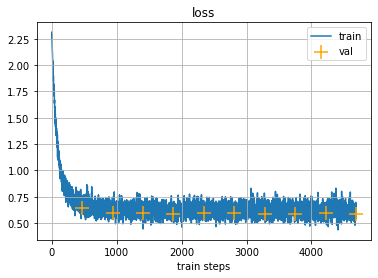

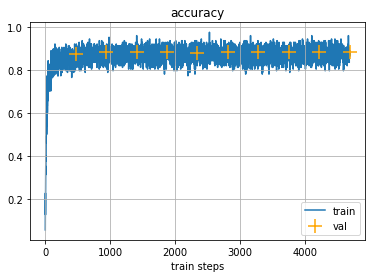

Epoch: 9, val loss: 0.591307332621345, val accuracy: 0.8825158476829529


In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.05)
train(model, opt, 10)

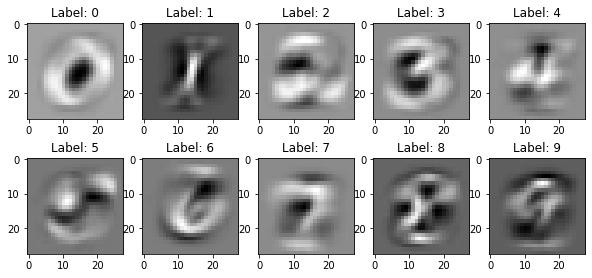

In [ ]:
weights = model._modules['1'].weight.detach().numpy()
plt.figure(figsize=[10, 12])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

## BatchNorm2d

Реализуйте BatchNormalization слой для сверточной сети

* `nn.Parameter` нужно использовать для того, чтобы определить обучаемые параметры для сети
* буфферы нужно использовать для других тензоров, которые должны возвращаться в `state_dict()` модели, но для которых не нужно вычислять градиенты
* В чем разница между register_buffer, register_parameter: [тык](https://stackoverflow.com/questions/57540745/what-is-the-difference-between-register-parameter-and-register-buffer-in-pytorch)
* для буфферов не должны считаться градиенты, используте `.detach()` при операциях с тензорами, по которым считаются градиенты
* Для того, чтобы заработал [broadcast](https://pytorch.org/docs/stable/notes/broadcasting.html) между тензорами разных рзаменностей, можно использовать .view(1, -1, 1, 1)


In [4]:
torch.arange(3).shape, torch.arange(3).view(1, -1, 1, 1).shape

(torch.Size([3]), torch.Size([1, 3, 1, 1]))

In [5]:
torch.zeros([2, 3, 4, 4]) - torch.arange(3).view(1, -1, 1, 1)

tensor([[[[ 0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.]],

         [[-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.]],

         [[-2., -2., -2., -2.],
          [-2., -2., -2., -2.],
          [-2., -2., -2., -2.],
          [-2., -2., -2., -2.]]],


        [[[ 0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.]],

         [[-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.]],

         [[-2., -2., -2., -2.],
          [-2., -2., -2., -2.],
          [-2., -2., -2., -2.],
          [-2., -2., -2., -2.]]]])

In [6]:
a = torch.zeros([2, 3, 4, 4]) - torch.arange(3).view(1, -1, 1, 1)
torch.mean(a, dim=[0,2,3])
torch.tensor(0, dtype=torch.long, device=None) + 1

tensor(1)

In [25]:
# эту ячейку в тестах я буду сохранять в отдельный файл, поэтому не нужно
# изменять имя класса, убирать импорты (добавлять, в принципе, можно)
# добавлять в ячейку какой-то посторонний код, не связанный с реализацией этого класса

from typing import Optional, Any
import torch
import torch.nn as nn
import torch.nn.functional as F

class BatchNorm2dLayer(nn.Module): # не надо переименовыввать этот класс
    """
    https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
    """

    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None):
        super().__init__()

        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.num_features = num_features

        self.track_running_stats = track_running_stats

        if self.affine:
            self.weight = nn.Parameter(torch.ones(num_features, device=device), requires_grad=True)
            self.bias = nn.Parameter(torch.zeros(num_features, device=device), requires_grad=True)
        else:
            self.register_parameter("weight", None)
            self.register_parameter("bias", None)

        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features, device=device))
            self.register_buffer('running_var', torch.ones(num_features, device=device))

            self.register_buffer('num_batches_tracked',
                                 torch.tensor(0, dtype=torch.long, device=device))

            self.num_batches_tracked: Optional[torch.Tensor]
        else:
            self.register_buffer("running_mean", None)
            self.register_buffer("running_var", None)
            self.register_buffer("num_batches_tracked", None)


    def forward(self, input_tensor):
        
        # вычисляем mean + var по каналам для всего батча
        # Обратите внимание на предложение в документации "The standard-deviation is calculated via ..."
        # 
        # В результате должно получиться 2 тензора размерности [ self.num_features ] (средние, дисперсии для всех каналов)
        # Обратите внимание, что mean/var принимает аргументом параметр dim: `dim is a list of dimensions, reduce over all of them.`
        # То есть если передать список размерностей, то среднее будет считаться по всем указанным размерностям. Размерности нумеруются с нуля
        # 
        # То есть для тензора [ batch_size, channels, width, heigth ] .mean(dim=[2, 3]) посчитает среднее значения пикселей для каждой картинке.
        # Ваша задача усреднить по ВСЕМ картинкам и всем пикселям, нужно добавить еще одну размерность в список размерностей для усреднения

        mean = torch.mean(input_tensor, dim=[0, 2, 3])
        # print(mean.shape, self.num_features)
        var = torch.var(input_tensor, dim=[0, 2, 3], unbiased=False)
        # print(var.shape, self.num_features)

        if self.track_running_stats and self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
            self.num_batches_tracked += 1
            self.running_mean.detach()
            self.running_var.detach()
            self.num_batches_tracked.detach()
            # pass
            # обновляем self.running_var, self.running_mean, self.num_batches_tracked
            # Как обновить? Смотрите Note в документации BatchNorm2d
            # не забываем сделать detach
            # CODE

        if self.track_running_stats and not self.training:
            mean = self.running_mean
            var = self.running_var
            # pass
            # в этом случае исползуем подсчитанные во время тренировки средние значения по каналам
            # CODE


        # по формуле из документации нормализуем данные
        # обратите внимание на хинты перед этой ячейкой 
        # CODE
        # print(mean.shape, var.shape, input_tensor.shape)
        # print(input_tensor.shape, mean.shape, mean.view(1, -1, 1, 1).shape, (input_tensor - mean.view(1, -1, 1, 1)).shape, ((var + self.eps) ** 0.5).shape)
        input_tensor_hat = (input_tensor - mean.view(1, -1, 1, 1)) / ((var + self.eps) ** 0.5).view(1, -1, 1, 1)

        # если есть обучаемые параметры для аффинного преобразования, делаем это преобразование
        # тут тоже пригодятся хинты
        # CODE
        if self.affine:
            # print(self.weight.shape, input_tensor_hat.shape, self.bias.view(1, -1, 1, 1).shape, self.bias.shape)
            return self.weight.view(1, -1, 1, 1) * input_tensor_hat + self.bias.view(1, -1, 1, 1) 
        else:
            return input_tensor_hat  # todo

    def __repr__(self):
        return (
            "BatchNorm2dLayer({num_features}, eps={eps}, momentum={momentum}, affine={affine}, "
            "track_running_stats={track_running_stats})".format(**self.__dict__)
        )

In [26]:
from tqdm.auto import tqdm

def _test_batch_norm(bn, torch_bn, description="train"):

    batch_size = 2
    image_size = (3, 3)

    for i in range(3):
        batch = torch.rand([ batch_size, torch_bn.num_features, *image_size ])
        batch_clone = batch.clone()

        my_bn_out    = bn.forward(batch)
        torch_bn_out = torch_bn.forward(batch)

        # print("my_bn_out", my_bn_out)
        # print("torch_bn_out", torch_bn_out)

        assert (batch_clone == batch).all(), "batch was not changed inside module"

        # check buffers
        assert torch_bn.num_batches_tracked == bn.num_batches_tracked, f"{description}: num_batches_tracked mismatch: {torch_bn.num_batches_tracked} == {bn.num_batches_tracked}"
        
        if torch_bn.track_running_stats:
            assert bn.running_mean.requires_grad == False, "bn.running_mean should not requires_grad. Use .detach() for per batch means"
            assert bn.running_var.requires_grad == False, "bn.running_var should not requires_grad. Use .detach() for per batch vars"

            assert torch_bn.running_mean.allclose(bn.running_mean), f"{description}: running_mean mismatch: {torch_bn.running_mean} == {bn.running_mean}"
            assert torch_bn.running_var.allclose(bn.running_var, rtol=0.1), f"{description}: running_var mismatch: {torch_bn.running_var} == {bn.running_var}"

        # check parameters
        if torch_bn.affine:
            assert torch_bn.weight.allclose(bn.weight), f"{description}: weight mismatch: {torch_bn.weight} == {bn.weight}"
            assert torch_bn.bias.allclose(bn.bias), f"{description}: bias mismatch: {torch_bn.bias} == {bn.bias}"

        assert torch_bn_out.allclose(my_bn_out, atol=1e-04, rtol=0.1), f"{description}: {i} torch normalized batch equals to yours one"

    return


def test_batch_norm_2d():

    with torch.no_grad():

        for num_channels in (1, 2, 3):

            test_descr = f"train: [channels={num_channels}]"

            bn = BatchNorm2dLayer(num_channels, track_running_stats=True).train()
            torch_bn = nn.BatchNorm2d(num_channels, track_running_stats=True).train()

            _test_batch_norm(bn, torch_bn, description=test_descr)

            bn.eval()
            torch_bn.eval()
            
            test_descr = f"eval: [channels={num_channels}]"
            _test_batch_norm(bn, torch_bn, description=test_descr)
        
def test_batch_norm_2d_do_not_track_running_stats():

    with torch.no_grad():

        for num_channels in (1, 2, 3):

            test_descr = f"train: [channels={num_channels}]"

            bn = BatchNorm2dLayer(num_channels, track_running_stats=False).train()
            torch_bn = nn.BatchNorm2d(num_channels, track_running_stats=False).train()

            _test_batch_norm(bn, torch_bn, description=test_descr)

            bn.eval()
            torch_bn.eval()
            
            test_descr = f"eval: [channels={num_channels}]"
            _test_batch_norm(bn, torch_bn, description=test_descr)
        
def test_batch_norm_2d_do_not_track_running_stats_not_affine():

    with torch.no_grad():

        for num_channels in (1, 2, 3):

            test_descr = f"train: [channels={num_channels}]"

            bn = BatchNorm2dLayer(num_channels, track_running_stats=False, affine=False).train()
            torch_bn = nn.BatchNorm2d(num_channels, track_running_stats=False, affine=False).train()

            _test_batch_norm(bn, torch_bn, description=test_descr)

            bn.eval()
            torch_bn.eval()
            
            test_descr = f"eval: [channels={num_channels}]"
            _test_batch_norm(bn, torch_bn, description=test_descr)
        


for _ in tqdm(range(100)):
    test_batch_norm_2d()
    test_batch_norm_2d_do_not_track_running_stats()
    test_batch_norm_2d_do_not_track_running_stats_not_affine()

  0%|          | 0/100 [00:00<?, ?it/s]

Обучите сверточную сеть с batch_norm'ом

In [27]:
modelBN = nn.Sequential(
    BatchNorm2dLayer(1),
    nn.Conv2d(1, 2, kernel_size=3, padding=1),
    nn.ReLU(),
    BatchNorm2dLayer(2),
    nn.Conv2d(2, 4, kernel_size=3, padding=1),
    nn.ReLU(),
    BatchNorm2dLayer(4),
    nn.Conv2d(4, 1, kernel_size=3, padding=1),
    nn.Flatten(1),
    nn.Linear(28 * 28 * 1, num_classes),
    nn.LogSoftmax(dim=-1)
    )

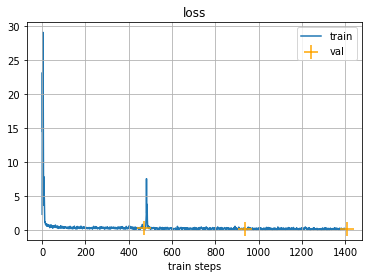

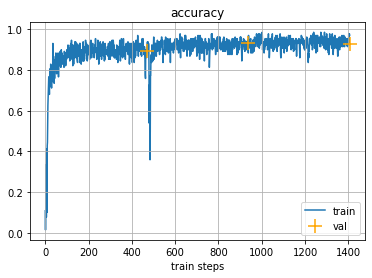

Epoch: 2, val loss: 0.2510087635556731, val accuracy: 0.9243472814559937


In [28]:
opt = torch.optim.RMSprop(modelBN.parameters(), lr=0.01)
train(modelBN, opt, 3)

In [29]:
for m in modelBN.modules():
    if isinstance(m, BatchNorm2dLayer):
        print(m)
        print("Parameters:", "weight       =", m.weight.data,  "bias        =", m.bias.data)
        print("Buffers:   ", "running_mean =", m.running_mean, "running_var =", m.running_var)
        print("\n")

BatchNorm2dLayer(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Parameters: weight       = tensor([1.1237]) bias        = tensor([0.2026])
Buffers:    running_mean = tensor([0.1299]) running_var = tensor([0.0943])


BatchNorm2dLayer(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Parameters: weight       = tensor([1.0698, 0.4493]) bias        = tensor([-0.0663, -0.3449])
Buffers:    running_mean = tensor([0.7632, 0.3601], grad_fn=<AddBackward0>) running_var = tensor([2.8663, 0.7889], grad_fn=<AddBackward0>)


BatchNorm2dLayer(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Parameters: weight       = tensor([0.3562, 0.1099, 0.2305, 0.2446]) bias        = tensor([ 0.0065,  0.0201, -0.0201, -0.0505])
Buffers:    running_mean = tensor([0.5872, 0.6716, 0.0635, 0.1045], grad_fn=<AddBackward0>) running_var = tensor([0.1989, 0.2716, 0.0968, 0.1889], grad_fn=<AddBackward0>)


